In [1]:
# based on this project: https://www.blog.datahut.co/post/scraping-amazon-best-seller-data-using-python

# Importing libraries
import time
import random
import csv  
from csv import writer
from bs4 import BeautifulSoup
import pandas as pd
pd.options.mode.chained_assignment = None
import undetected_chromedriver as uc #driver that can't be detected by websites as a scraper
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
# Function to delay some process
def delay():
    # time.sleep(random.randint(1, 3))
    time.sleep(1)

# Scrolling down the page in order to overcome Lazy Loading
def lazy_loading(n):
    element = driver.find_element(By.TAG_NAME, 'body')
    count = 0
    while count < n:
        element.send_keys(Keys.PAGE_DOWN)
        delay()
        count += 1

In [3]:
# Function to fetch the product links of products
def fetch_product_links_and_ranks():
    content = driver.page_source
    homepage_soup = BeautifulSoup(content, 'html.parser')

    all_products = homepage_soup.find('div', attrs={"class": "p13n-desktop-grid"})
    for product_section in all_products.find_all('div', {'id': 'gridItemRoot'}):
        for product_link in product_section.find_all('a',{'tabindex':'-1'}):

            if product_link['href'].startswith('https:'):
                url_to_be_saved = product_link['href']
            else:
                url_to_be_saved = 'https://www.amazon.com.mx' + product_link['href']
            # print("obtained url: ", url_to_be_saved)
            
            df = pd.read_csv('links_amazon.csv')
            if url_to_be_saved not in df.product_url.values:

                if df.empty:
                    indice = 0
                else:
                    indice = df.number.iloc[-1]

                # insert row of information to .csv file
                data = [indice + 1, url_to_be_saved, "no"]
                # Open our existing CSV file in append mode and Create a file object for this file
                with open('links_amazon.csv', 'a', encoding="utf-8", newline='') as f_object:
                
                    # Pass this file object to csv.writer() and get a writer object
                    writer_object = writer(f_object)
                
                    # Pass the list as an argument into the writerow() and Close the file object
                    writer_object.writerow(data)
                    f_object.close()

options = webdriver.ChromeOptions()
options.add_argument(r"--user-data-dir=C:\Users\j50022283\AppData\Local\Google\Chrome\User Data\Default")

driver = uc.Chrome(options=options)
# driver = webdriver.Chrome()

# Fetching the product links of all items
for page in range(1,3): # to iterate over the 2 pages in which the products are divided into
    start_url = f'https://www.amazon.com.mx/gp/bestsellers/books/ref=zg_bs_pg_{page}_books?ie=UTF8&pg={page}'

    driver.get(start_url)
    print("Scrapping main", start_url)
    lazy_loading(16)                # to overcome lazy loading
    fetch_product_links_and_ranks() # to fetch the links to products 


Scrapping main https://www.amazon.com.mx/gp/bestsellers/books/ref=zg_bs_pg_1_books?ie=UTF8&pg=1
Scrapping main https://www.amazon.com.mx/gp/bestsellers/books/ref=zg_bs_pg_2_books?ie=UTF8&pg=2


In [4]:
df = pd.read_csv ('links_amazon.csv')

print(df)
# print(df.already_scraped.value_counts())

    number                                        product_url already_scraped
0        1  https://www.amazon.com.mx/H%C3%A1bitos-At%C3%B...              no
1        2  https://www.amazon.com.mx/Identifica-resuelve-...              no
2        3  https://www.amazon.com.mx/El-Principito-Antoin...              no
3        4  https://www.amazon.com.mx/Beyond-Story-Cr%C3%B...              no
4        5  https://www.amazon.com.mx/Descubre-mejores-ami...              no
..     ...                                                ...             ...
75      76  https://www.amazon.com.mx/%C3%81lgebra-4a-Edic...              no
76      77  https://www.amazon.com.mx/Jumbo-Temporada-Grac...              no
77      78  https://www.amazon.com.mx/El-principito-EDICIO...              no
78      79  https://www.amazon.com.mx/Hay-triceratops-casa...              no
79      80  https://www.amazon.com.mx/Vibra-brilla-siempre...              no

[80 rows x 3 columns]


In [5]:
import re

options = webdriver.ChromeOptions()
options.add_argument(r"--user-data-dir=C:\Users\j50022283\AppData\Local\Google\Chrome\User Data\Default") #change this to your profile path, you can get it on google in this link: 'chrome://version/'

driver = uc.Chrome(options=options)
# driver = webdriver.Chrome()

for index in df.index:
    url = df.product_url[index]

    # if index == 60:break

    if df.already_scraped[index] == 'no':
        driver.get(url)
        page_content = driver.page_source
        soup = BeautifulSoup(page_content, 'html.parser')
        print("\n" + str(df.number[index]) + ".- The following URL is being scrapped out: ", url)
        
        # getting name
        try:
            name_of_product = soup.find('span', attrs={"id": "productTitle"}).text.strip()
        except:
            name_of_product = 'unavailable'
        print("name_of_product:",name_of_product)

        # getting stars
        try:
            rating_stars = soup.find('span', attrs={"id": "acrPopover"})["title"]
        except:
            rating_stars = 'unavailable'
        print("rating_stars:",rating_stars)

        # getting total number of reviews
        try:
            Customer_Reviews = soup.find('span', attrs={"id": "acrCustomerReviewText"}).text.strip()
        except:
            Customer_Reviews = 'unavailable'
        print("Customer_Reviews:",Customer_Reviews)

        # getting description of books (several paragraphs)
        try:
            description_of_product = soup.find('div', attrs={"class": "a-expander-content a-expander-partial-collapse-content"})
            description_of_product = description_of_product.find_all('span')
            description = []
            descriptionString = ""
            for span in description_of_product:
                description.append(span.text.strip())
            descriptionString = ' \n'.join(description)
            print("descriptionString:",descriptionString)
        except:
            descriptionString = 'unavailable'
            print("descriptionString:",descriptionString)

        # getting specific details of book
        try:
            details_of_product = soup.find('div', attrs={"id": "detailBullets_feature_div"})
            details_of_product = details_of_product.find_all('span', attrs={"class": "a-list-item"})
            detailsA = []
            detailsB = []
            detailsString = ""
            for span in details_of_product:
                a = span.find('span', attrs={"class": "a-text-bold"})
                b = span.find('span', attrs={"class": ""})
                a = re.sub('\u200f\n', '', str(a))
                a = re.sub('\u200e\n', '', str(a))
                a = re.sub('\n', '', str(a))
                a = re.sub(':', '', str(a))
                a = BeautifulSoup(str(a), 'html.parser').text.strip()
                b = BeautifulSoup(str(b), 'html.parser').text.strip()

                detailsA.append(a)
                if b != None and b != 'None': 
                    detailsB.append(b)

            detailsC = []
            for i in range(len(detailsB)):
                detailsC.append(str(detailsA[i]) + ' : ' + str(detailsB[i]))
            detailsString = ' \n'.join(detailsC)
            
            # print("detailsStringA:",detailsA)
            # print("detailsStringB:",detailsB)
            # print("detailsStringC:",detailsC)
            print("detailsString:",detailsString)
        except:
            detailsString = 'unavailable'
            print("detailsString:",detailsString)
            
        # getting author (more than 1 author migth appear)
        try:
            authors_detail = soup.find('div', attrs={"id": "bylineInfo_feature_div"})
            authors_detail = authors_detail.find_all('span', attrs={"class": "author notFaded"})

            authors = []
            authorsString = ""
            for author in authors_detail:
                authors.append(author.text.strip())

            for i in range(len(authors)):
                authors[i] = re.sub('\n', '', authors[i])
            authorsString = ' '.join(authors)

            print("authorsString:",authorsString)

        except:
            authorsString =  'unavailable'
            print("authorsString:", authorsString)

        # getting url of comments to scrape them out later on
        try:
            all_reviews_link = 'https://www.amazon.com.mx' + soup.find('a', attrs={"data-hook": "see-all-reviews-link-foot"})["href"]
        except:
            all_reviews_link = 'unavailable'
        print("all_reviews_link:",all_reviews_link)


        # insert row of information to .csv file
        data = [df.number[index], name_of_product, rating_stars, Customer_Reviews, descriptionString, detailsString, authorsString, all_reviews_link, "no"]
        
        # Open our existing CSV file in append mode and Create a file object for this file
        with open('books_amazon.csv', 'a', encoding="utf-8", newline='') as csvfile:
        
            # Pass this file object to csv.writer() and get a writer object
            writer_object = writer(csvfile)
        
            # Pass the list as an argument into the writerow() and Close the file object
            writer_object.writerow(data)
            csvfile.close()

        if data:
            df.already_scraped[index] = 'yes'
            df.to_csv('links_amazon.csv', index=False)



1.- The following URL is being scrapped out:  https://www.amazon.com.mx/H%C3%A1bitos-At%C3%B3micos-James-Clear/dp/6077476714/ref=zg_bs_g_books_sccl_1/137-7391295-0351748?psc=1
name_of_product: Hábitos Atómicos
rating_stars: 4.8 de 5 estrellas
Customer_Reviews: 10,894 calificaciones
descriptionString: HÁBITOS ATÓMICOS parte de una simple pero poderosa pregunta: ¿Cómo podemos vivir mejor? Sabemos que unos buenos hábitos nos permiten mejorar significativamente nuestra vida, pero con frecuencia nos desviamos del camino: dejamos de hacer ejercicio, comemos mal, dormimos poco, despilfarramos. ¿Por qué es tan fácil caer en los malos hábitos y tan complicado seguir los buenos? James Clear nos brinda fantásticas ideas basadas en investigaciones científicas, que le permiten revelarnos cómo podemos transformar pequeños hábitos cotidianos para cambiar nuestra vida y mejorarla. Esta guía pone al descubierto las fuerzas ocultas que moldean nuestro comportamiento —desde nuestra mentalidad, pasando p

If you get 

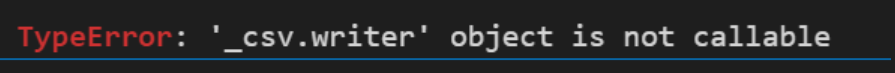

Just try closing and opening VS Code

Additionally, if you run one of the cells belows to erase a .csv file content, you should restart vs code as well

In [8]:
#just run this cell in case of wanting to erase all links_amazon.csv content 
header = ['number', 'product_url', 'already_scraped']

with open('links_amazon.csv', 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

In [9]:
#just run this cell in case of wanting to erase all books_amazon.csv content 

header = ['number', 'name', 'stars', 'number_of_reviews', 'description', 'details', 'author', 'opinions_url', 'opinions_already_scraped']

with open('books_amazon.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

df = pd.read_csv('links_amazon.csv')
df.already_scraped = 'no'
df.to_csv('links_amazon.csv', index=False)

In [5]:
#just run this cell in case of wanting to erase all opinions_amazon.csv content 
header = ['number', 'name', 'stars', 'title', 'date', 'text']

with open('opinions_amazon.csv', 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

df = pd.read_csv('books_amazon.csv')
df.opinions_already_scraped = 'no'
df.to_csv('books_amazon.csv', index=False)

In [3]:
df = pd.read_csv('books_amazon.csv')

print(df)

    number                                               name  \
0        1                                   Hábitos Atómicos   
1        2  Este dolor no es mío. Identifica y resuelve lo...   
2        3                                      El Principito   
3        4        Beyond the Story. Crónica de 10 años de BTS   
4        5                      Descubre a los mejores amigos   
..     ...                                                ...   
75      76                               Álgebra (4a Edición)   
76      77                         Jumbo Onix Nueva Temporada   
77      78            El principito: (EDICION UNICA COMPLETA)   
78      79            Hay Un Triceratops en la Casa del Árbol   
79      80                         Vibra alto, brilla siempre   

                 stars      number_of_reviews  \
0   4.8 de 5 estrellas  10,894 calificaciones   
1   4.7 de 5 estrellas   4,344 calificaciones   
2   4.9 de 5 estrellas   8,813 calificaciones   
3          unavailable 

In [4]:
# getting opinions

options = webdriver.ChromeOptions()
options.add_argument(r"--user-data-dir=C:\Users\j50022283\AppData\Local\Google\Chrome\User Data\Default")

driver = uc.Chrome(options=options)
# driver = webdriver.Chrome()

for index in df.index:
    if index == 10:break

    url = df.opinions_url[index]

    if df.opinions_already_scraped[index] == 'no' and df.opinions_url[index] != "unavailable":
        print("\n" + str(df.number[index]) + ".- The following URL is being scrapped out: ", url)
    
        driver.get(url)
        lazy_loading(8)
        
        page_content = driver.page_source
        soup = BeautifulSoup(page_content, 'html.parser')
        
        
        # getting opinions
        try:
            opinions = soup.find('div', attrs={"class": "a-section a-spacing-none reviews-content a-size-base"})
            opinions = opinions.find_all('div', attrs={"class": "a-section review aok-relative"})

            for opinion in opinions:
                # print(opinion)
                try:
                    name = opinion.find('span', attrs={"class": "a-profile-name"}).text.strip()
                except:
                    name = "unavailable"

                try: 
                    divRating_and_title = opinion.find('div', attrs={"class": "a-row"})
                    # print("a row", divRating_and_title)
                    rating = divRating_and_title.find('span', attrs={"class": "a-icon-alt"}).text.strip()
                    title = divRating_and_title.find('span', attrs={"class": ""}).text.strip()
                except:
                    rating = "unavailable"
                    title = "unavailable"

                try: 
                    opinion_date = opinion.find('span', attrs={"class": "a-size-base a-color-secondary review-date"}).text.strip()
                except:
                    opinion_date = "unavailable"

                try:   
                     divRating_opinion = opinion.find('div', attrs={"class": "a-row a-spacing-small review-data"})
                    #  print("divRating_opinion", divRating_opinion)
                     opinion_text = divRating_opinion.find('span', attrs={"class": ""}).text.strip()
                except:
                    opinion_text = "unavailable"

                # print("\n")
                # print(name)
                # print(rating)
                # print(title)
                # print(opinion_date)
                # print(opinion_text)
                
                data = [df.number[index], name, rating, title, opinion_date, opinion_text]
                print("\n", data)

                try: 
                    # Open our existing CSV file in append mode and Create a file object for this file
                    with open('opinions_amazon.csv', 'a', encoding="utf-8", newline='') as f_object:
                    
                        # Pass this file object to csv.writer() and get a writer object
                        writer_object = writer(f_object)
                    
                        # Pass the list as an argument into the writerow() and Close the file object
                        writer_object.writerow(data)
                        f_object.close()

                    if data:
                        df.opinions_already_scraped[index] = 'yes'
                        df.to_csv('books_amazon.csv', index=False)
                except:
                    print("failed saving data")
                    

        except:
            opinions = 'opinions not available for this page'
            print(opinions)


1.- The following URL is being scrapped out:  https://www.amazon.com.mx/H%C3%A1bitos-At%C3%B3micos-James-Clear/product-reviews/6077476714/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews

 [0, 'Cliente de Kindle', '5.0 de 5 estrellas', 'Súper hábitos atómicos', 'Revisado en México el 30 de agosto de 2023', 'Este libro me encantó, tienes muchas estrategias y sistemas para lograr tus metas y propósitos, con tan solo es empezando a crear el hábito, tener deseo anheló, un porqué para lograrlo, el cómo si puedo hacerlo, lo ame nos más que poner en marcha, sin duda tomar acción y mejor hecho que perfecto.  Gracias 😊']

 [0, 'Cliente de Kindle', '5.0 de 5 estrellas', 'Muy bueno', 'Revisado en México el 30 de agosto de 2023', 'Un punto fuerte a favor de este libro es la conexión de los consejos de James Clear con evidencia científica y un contexto ejemplificativo que vuelve atractiva cada lección y fácil de aterrizar en tu sistema de hábitos personal.']

 [0, 'Adriana Parra', '5.0

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=116.0.5845.142)
Stacktrace:
	GetHandleVerifier [0x008837C3+48947]
	(No symbol) [0x00818551]
	(No symbol) [0x0071C92D]
	(No symbol) [0x007036E5]
	(No symbol) [0x00768CDB]
	(No symbol) [0x00777113]
	(No symbol) [0x00764E86]
	(No symbol) [0x007416C7]
	(No symbol) [0x0074284D]
	GetHandleVerifier [0x00ACFDF9+2458985]
	GetHandleVerifier [0x00B1744F+2751423]
	GetHandleVerifier [0x00B11361+2726609]
	GetHandleVerifier [0x00900680+560624]
	(No symbol) [0x0082238C]
	(No symbol) [0x0081E268]
	(No symbol) [0x0081E392]
	(No symbol) [0x008110B7]
	BaseThreadInitThunk [0x76B500C9+25]
	RtlGetAppContainerNamedObjectPath [0x777F7B4E+286]
	RtlGetAppContainerNamedObjectPath [0x777F7B1E+238]
